In [4]:
#notes i think the old images did not work as it was a grayscale image where each different gray color was a float like 0.26 which is not good for crossentropyloss since it requires integers

# USAGE
# python train.py
# import the necessary packages
#from pyimagesearch.dataset2 import SegmentationDataset

from torch.utils.data import DataLoader
#from torchvision import transforms
import torchvision.transforms as transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
from PIL import Image 

In [5]:
import config

In [6]:
mask = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/masks/mask_101.png")

In [7]:
mask = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/masks/mask_101.png")
img = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/imgs/img_101.png")
anno = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/annos/anno_101.jpg")
annoIntMapMask = Image.open("/scratch/aniemcz/CAT/Brown_Field/Train/annos/int_maps/mask_101.png")

yeet = Image.open("/scratch/aniemcz/CAT/mixed/Train/annos/int_maps/anno_pln_414.png")
yeet2 = Image.open("/scratch/aniemcz/CAT/mixed/Train/imgs/img_pln_414.png")
np.array(anno).shape
#We want the img as input and the annoIntMapMask as the target / labels

NameError: name 'np' is not defined

In [9]:
# import the necessary packages
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
import os
from PIL import Image 
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, root, split, transforms=None):
        #loop through each location
        #Go into the split folder
        #Go into images and masks since they will be in pairs
        
        # store the image and mask filepaths, and augmentation
        # transforms
        self.root = root
        
        self.transforms = transforms
        
        #split is included b/c the data has a train, val, and test folder 
        #ex: urRootPath/Brown_Field/Train/annos/int_maps/mask_101.png  (mask in train folder)
        #ex: urRootPath/ (img in val folder)
        
        #stores the image paths and mask paths (duh)
        self.image_paths = []
        self.mask_paths = []
        
        #weird, int_map masks in brown_field is named mask_numberHere.png while in Powerline its anno_pln_numberHere.png
        for trail_name in os.listdir(self.root):
            split_path = os.path.join(root, trail_name, split.capitalize())
            imgs_path = os.path.join(split_path, "imgs")
            masks_path = os.path.join(split_path, "annos/int_maps/")
            for mask_name in os.listdir(masks_path):
                    
                    #Get the int_map mask first
                    mask_path = os.path.join(masks_path, mask_name)
                    self.mask_paths.append(mask_path)
            
                    #Get the corresponding image to that map_mask
                    image_name = "img_" + mask_name.split("_", 1)[1] #need to change file name a little for images
                    image_path = os.path.join(imgs_path, image_name)
                    self.image_paths.append(image_path)
        
        #The images are separated in different folders by trail so we need to loop through those
        #both images and masks have the same trail (b/c image must have a corresponding mask) so we only loop through that once

                    
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.image_paths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image, mask = self.transforms(image, mask)        
        # return a tuple of the image and its mask
        return (image, mask)


In [13]:

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image = t(image)
            target = t(target)
        
        #Numpy Array stores image data as [Height, Width, Num_Color_Channels]
        #Pytorch Tensor stores image data as [Num_Color_Channels, Height, Width]

        #We cannot use transforms.ToTensor() for masks as it normalizes the data between 0.0 and 1.0 which we dont want
        #So instead we first convert to numpy array and then to tensor of type int 64 to avoid this
        #Thus our integer labels in the image data is preserved
        
        #mask
        target = np.array(target)
        target = torch.tensor(target, dtype=torch.int64) #int64 b/c target (in this case masks) have to be int64 for crossEntropyLoss

        #however we do want to use ToTensor for images to normalize to help prevent giving too high of an initial value to color values
        #image
        toTensor = transforms.ToTensor()
        image = toTensor(image)
        
        return image, target

#WARNING: Do not use Transform.ToTensor as it normalizes the data [0.0-1.0] which we don't want
#Aug apply to mask and img
transform = []
#WARNING: Interpolation nearrest is needed to prevent the pixels in mask from being blurred when stretched thus messing up the labelIds
#transform.append( transforms.Resize((config.INPUT_IMAGE_HEIGHT,config.INPUT_IMAGE_WIDTH), interpolation=Image.NEAREST )) 
transform = Compose(transform)

trainDS = SegmentationDataset('/scratch/aniemcz/CAT', split='Train',
	transforms=transform)
testDS = SegmentationDataset('/scratch/aniemcz/CAT', split='Test',
	transforms=transform)


In [ ]:
'''
image sizes in the dataset:
 torch.size([3, 452, 720]),
 torch.Size([3, 604, 960]),
 torch.Size([3, 644, 1024]),
 torch.Size([3, 1208, 1920])}
'''

In [20]:
trainDS[500][0].shape
#644 x 1024
#452 x 720
#
len(trainDS)

s = set()

for i in trainDS:
    s.add(i[0].shape)

In [21]:
s

{torch.Size([3, 452, 720]),
 torch.Size([3, 604, 960]),
 torch.Size([3, 644, 1024]),
 torch.Size([3, 1208, 1920])}

Class 0: 14043408 pixels
Class 1: 11796812 pixels
Class 2: 6068316 pixels
Class 3: 9641288 pixels


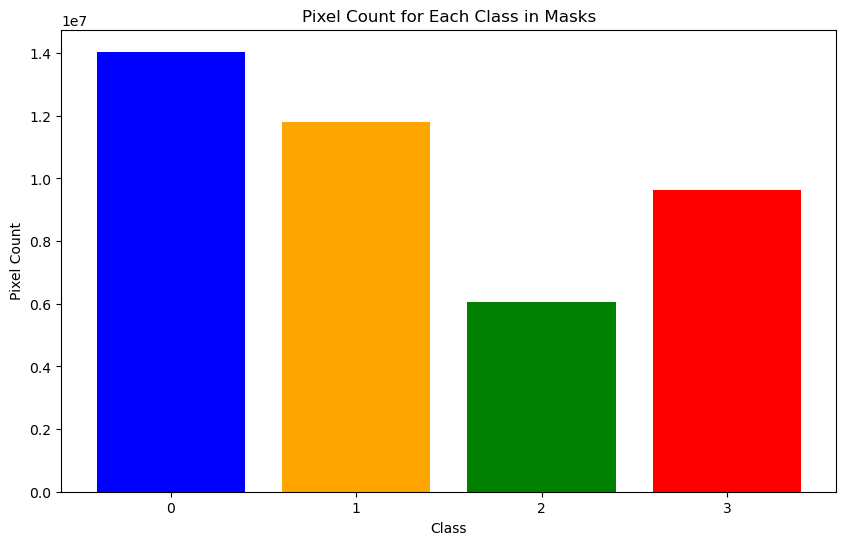

In [9]:
#Loop through each image mask pair and go through each pixel in the mask and count each class
from collections import Counter
import numpy as np

# Create an instance of the dataset (adjust the paths accordingly)
dataset = trainDS

# Initialize a Counter for tallying classes
class_counts = Counter()

# Loop through the dataset and count the classes in each mask
for _, mask in dataset:
    mask_np = np.array(mask)  # Convert the mask to a NumPy array
    class_counts.update(mask_np.flatten())  # Flatten the mask and update the counter

# Extract and print the counts for classes 0, 1, 2, 3
for i in range(4):
    print(f"Class {i}: {class_counts[i]} pixels")
    
# Extract counts for classes 0, 1, 2, 3
class_labels = [0, 1, 2, 3]
counts = [class_counts[label] for label in class_labels]

    # Plot the counts as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title('Pixel Count for Each Class in Masks')
plt.xticks(class_labels)
plt.show()

In [20]:
#Returns image and its mask
#print(len(os.listdir(trainDS.images_dir)))
print(np.unique(trainDS[198][1]))
#only four classes?
#print(trainDS[198][1].unique()) #img shape: torch.Size([3, 128, 128])
#mask shape: torch.Size([1, 128, 128])

[0 1 2 3]


In [38]:
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders

trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY)


[INFO] found 2975 examples in the training set...
[INFO] found 500 examples in the test set...


In [21]:
trainDS[198][1].shape

torch.Size([128, 128])

In [22]:
trainDS[198][1].unique()

tensor([0, 1, 2, 3])

In [43]:
from torch.nn import Softmax
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(config.NUM_EPOCHS):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	trainLoader = tqdm(trainLoader)
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	avgTrainLoss = totalTrainLoss / trainSteps
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}".format(
		avgTrainLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


100%|██████████| 47/47 [03:53<00:00,  4.97s/it]


[INFO] EPOCH: 1/5
Train loss: 1.163954


100%|██████████| 47/47 [03:53<00:00,  4.96s/it]


[INFO] EPOCH: 2/5
Train loss: 0.690106


100%|██████████| 47/47 [03:51<00:00,  4.93s/it]


[INFO] EPOCH: 3/5
Train loss: 0.612651


100%|██████████| 47/47 [03:54<00:00,  4.98s/it]


[INFO] EPOCH: 4/5
Train loss: 0.567190


100%|██████████| 47/47 [03:54<00:00,  4.99s/it]

[INFO] EPOCH: 5/5
Train loss: 0.536282
[INFO] total time taken to train the model: 1167.86s


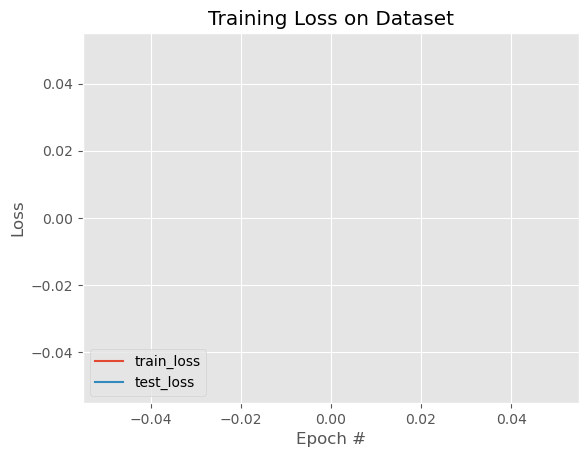

In [44]:

# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

[INFO] loading up test image paths...
[INFO] load up model...


/home/aniemcz/.conda/envs/universal/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/2975 [00:00<?, ?it/s]

Input shape is torch.Size([1, 3, 128, 128])
Output shape is torch.Size([1, 19, 128, 128])
Pred_labels shape is torch.Size([1, 128, 128])
tensor([11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11.])
Number of unique label ids is 7


  0%|          | 0/2975 [00:15<?, ?it/s]


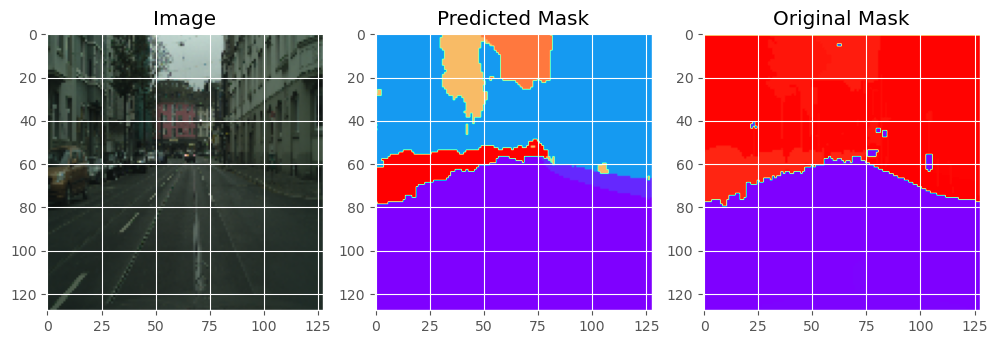

In [45]:
#MANY IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask, cmap="rainbow")
	ax[2].imshow(origMask, cmap="rainbow")
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
def make_predictions(model, dataLoader):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
		for idx, batch in enumerate(tqdm(dataLoader)):
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				X, y = batch # here 's' is the name of the file stored in the root directory
				X, y = X.to(config.DEVICE), y.to(config.DEVICE)
				toPilImage = transforms.ToPILImage()
				image = toPilImage(X.squeeze())
				origMask = toPilImage(y.squeeze().float())                
				
				print("Input shape is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				break #so it only iterates once          
	prepare_plot(image, pred_labels.squeeze(), origMask)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
trainLoaderEval = DataLoader(trainDS, shuffle=True,
	batch_size=1, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
make_predictions(unet, trainLoaderEval)


[INFO] loading up test image paths...
[INFO] load up model...
Input shape is torch.Size([1, 3, 128, 128])
Output shape is torch.Size([1, 19, 128, 128])
Pred_labels shape is torch.Size([1, 128, 128])
tensor([11., 11., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11., 11.,
        11., 11., 11., 11., 11., 11., 11., 11., 23., 23., 23., 23., 23., 23.,
        23., 23., 23., 23., 21., 21., 21., 21., 21., 21., 21., 21., 23., 23.,
        23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 23., 21.,
        11., 11.])
Number of unique label ids is 9


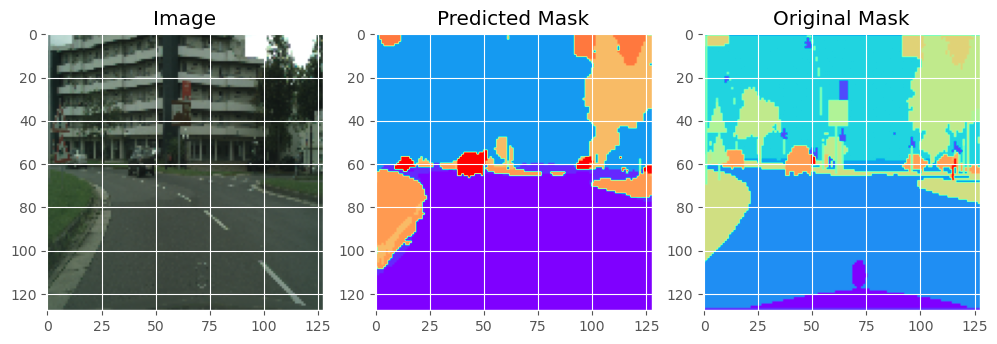

In [55]:
#SINGLE IMAGES
# USAGE
# python predict.py
# import the necessary packages
from pyimagesearch import config
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
from cityscapesscripts.helpers.labels import trainId2label as t2l
from PIL import Image 

def prepare_plot(origImage, predMask, origMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(predMask, cmap="rainbow")
	ax[2].imshow(origMask, cmap="rainbow")
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Predicted Mask")
	ax[2].set_title("Original Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()
def make_predictions(model, imagePath, maskPath):
	# set model to evaluation mode
	model.eval()
	with torch.no_grad():
				# load the image from disk, swap its color channels, cast it
				# to float data type, and scale its pixel values
				image = Image.open(imagePath)
				maskImg = Image.open(maskPath)
				# resize the image and make a copy of it for visualization
				image = image.resize((128,128), resample=Image.NEAREST)
				maskImg = maskImg.resize((128,128), resample=Image.NEAREST)
				PILtoTensor = transforms.ToTensor()
				X = PILtoTensor(image)
				X = X.to(config.DEVICE) #converts to tensor and moves to gpu if there is gpu
				X = X.unsqueeze(0) #this is the model normally expacts input in the form of torch.Size([batch_size, num_channels, height, width])
				#but X right now is in the form of [3, 128, 128] so we do unsqueeze to convert it to [1, 3, 128, 128] for predicting on our one image
				print("Input shape is {}".format(X.shape))
				predictions = model(X) #outputs a tensor of shape torch.Size([16, 19, 110, 220]) aka torch.Size([batch_size, num_classes, height, width])
				
				print("Output shape is {}".format(predictions.shape))
				
				#The basic idea of the softmax is that we will have our prediction
				#The prediction outputs a mask for each class where 
				predictions = torch.nn.functional.softmax(predictions, dim=1)
				pred_labels = torch.argmax(predictions, dim=1) 
				pred_labels = pred_labels.float()
				
				# Remapping the labels
				pred_labels = pred_labels.to('cpu')
				pred_labels.apply_(lambda x: t2l[x].id)
				
				# Resizing predicted images too original size
				#pred_labels = transforms.Resize((1024, 2048))(pred_labels)
				print("Pred_labels shape is {}".format(pred_labels.shape))
				print(pred_labels[0][0])
				flat = torch.flatten(pred_labels)
				test = flat.unique()
				print("Number of unique label ids is {}".format(len(test)) )
				#pred_labels = pred_labels.squeeze()                
	# Functions to save predictions as images 
	def save_as_images(tensor_pred, image_name):
		tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
		#filename = f"{folder}\{image_name}.png"
		filename = f"{image_name}.png"
		tensor_pred.save(filename)
	save_as_images(pred_labels, "yeet")
	prepare_plot(image, pred_labels.squeeze(), maskImg)
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
#imgPath = "dataset/data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
#maskPath = "dataset/data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png"
maskPath = "dataset/data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png"
imgPath = "dataset/data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png"
make_predictions(unet, imgPath, maskPath)
